In [589]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as funct
import gymnasium as gym
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
from time import sleep
from IPython import display
import copy
from itertools import count
import operator

In [590]:
#Just to get rid of annoying warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=np.VisibleDeprecationWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [591]:
env = gym.make("CartPole-v1")

In [592]:
#plot the result (score/fitness after episodes)
def plot(scores, ylabel = "Fitness of the best individual"):
    plt.plot(scores, color="r")
    plt.xlabel("Episode")
    plt.ylabel(ylabel)
    plt.show()

In [593]:
class NN(nn.Module):
    """A Feed Forward Neural Network used for Deep-Q-Learning to solve the cartpole problem."""
    def __init__(self, obs_dim = env.observation_space.shape, n_actions = env.action_space.n):
        super(NN, self).__init__()      
        # The input (an observation/a state) has shape (4,) [cart pos, cart vel, pole angle, pole angular vel]
        self.fc1 = nn.Linear(*obs_dim, 128) # * to convert tuple (4,) to 4
        self.fc21 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions) # n_actions == 2

        self.optimizer = optim.Adam(self.parameters(), lr=1e-4)
        self.loss = nn.MSELoss()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, x):
        x = funct.relu(self.fc1(x))
        x = funct.relu(self.fc21(x))
        return self.fc3(x)

In [594]:
ELITE, FITNESSPROPORTIONALE, TURNIER, RANG = range(4)

In [595]:
class Agent():
    # represents the agent of the RL
    def __init__(self, obs_dim = env.observation_space.shape, n_actions = env.action_space.n, 
                 eps = 0.05, popSize=20):
        
        self.obs_dim = obs_dim
        self.n_actions = n_actions
        self.action_space = [i for i in range(n_actions)]
        self.eps = eps
        self.popSize = popSize
        self.population = [(NN(),0) for _ in range(self.popSize)]


    #Choose the next action, based on the current state
    def pick_action(self, state, nn):
        if np.random.random() > self.eps:
            actions = nn.forward(state) 
            action =  torch.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)
        return action
    #Trains the NN 
    def train(self, max_iter, crossover, reps, selection_type = ELITE, plot_score = True):
        iter = 0
        scores = []
        self.population = self.fitness(reps=reps,pop=self.population)
        while iter < max_iter and self.population[0][1] < 500:
            children = self.reprod(crossover=crossover)
            self.mutation(children)
            children = self.fitness(reps=reps, pop=children)
            self.population.extend(children)
            self.selection(selection_type = selection_type)
            iter += 1
            scores.append(self.population[0][1])
            if plot_score:
                display.clear_output()
                plot(scores=scores)
        
        return iter
            

    #Calculates the fitness of a population. The fitness is the average score after "reps" games 
    def fitness(self, reps, pop):
        new_pop = []
        for p in pop:
            sum = 0
            for _ in range(reps):
                sum += self.play(p[0])
            new_pop.append((p[0],sum/reps))
        return new_pop
    

    def selection(self, selection_type = ELITE):

        match selection_type:
            
            case 0:
                """Elitist Selection"""
                sortedPop = sorted(self.population, key=operator.itemgetter(1), reverse=True)
                self.population = sortedPop[:self.popSize]
            
            case 1:
                """Fitnessproportionale  Selection"""
                f_sum = 0
                for indiv in self.population:
                    f_sum += indiv[1]
                p_values = []
                for indiv in self.population:
                    p_values.append(indiv[1]/f_sum)

                choice = np.random.choice(a = range(len(self.population)), size = self.popSize,replace=False,p = p_values)
                new_pop = [self.population[c] for c in choice]
                sortedPop = sorted(new_pop, key=operator.itemgetter(1), reverse=True)
                self.population = sortedPop

            case 2:
                """Turnier  Selection"""
                idx = [i for i in range(len(self.population))]
                np.random.shuffle(idx)
                winner_l = []
                for i in range(0,len(self.population),2):
                    if self.population[idx[i]][1] > self.population[idx[i+1]][1]:
                        winner_l.append(idx[i])
                    else:
                        winner_l.append(idx[i+1])

                new_pop = [self.population[w] for w in winner_l]
                sortedPop = sorted(new_pop, key=operator.itemgetter(1), reverse=True)
                self.population = sortedPop
            
            case 3:
                """Rang  Selection"""
                sortedPop = sorted(self.population, key=operator.itemgetter(1), reverse=True)
                sp = 1.5
                n = len(self.population)
                p_values = [(1/n * (sp - (2*sp-2)*(i-1)/(n-1))) for i in range(1,n+1)]

                choice = np.random.choice(a = range(len(self.population)), size = self.popSize,replace=False,p = p_values)
                new_pop = [self.population[c] for c in choice]
                sortedPop = sorted(new_pop, key=operator.itemgetter(1), reverse=True)
                self.population = sortedPop
                

    #mutates the childrens
    def mutation(self, children, mutate_bias = False):

        for c in children:
            nn = c[0]
            nn.fc1.weight = torch.nn.Parameter(nn.fc1.weight.add(torch.Tensor(np.random.normal(size=np.shape(nn.fc1.weight)))))
            nn.fc21.weight = torch.nn.Parameter(nn.fc21.weight.add(torch.Tensor(np.random.normal(size=np.shape(nn.fc21.weight)))))
            nn.fc3.weight = torch.nn.Parameter(nn.fc3.weight.add(torch.Tensor(np.random.normal(size=np.shape(nn.fc3.weight)))))

            if mutate_bias:  #not recommended
                nn.fc1.bias = torch.nn.Parameter(nn.fc1.bias.add(torch.Tensor(np.random.normal(size=np.shape(nn.fc1.bias)))))
                nn.fc21.bias = torch.nn.Parameter(nn.fc21.bias.add(torch.Tensor(np.random.normal(size=np.shape(nn.fc21.bias)))))
                nn.fc3.bias = torch.nn.Parameter(nn.fc3.bias.add(torch.Tensor(np.random.normal(size=np.shape(nn.fc3.bias)))))

    #Reproduces the population. Without crossover: population is duplicated
    def reprod(self, crossover = False):

        new = []
        for nn in self.population:
            new.append(copy.deepcopy(nn))

        #Crossover: The values of the weight maxtrixes are swapped with a probability x (0.5)
        if crossover:
            for i in range(0,self.popSize,2):
                nn1 = new[i][0]
                nn2 = new[i+1][0]
                
                for x in range(np.shape(nn1.fc1.weight)[0]):
                    for y in range(np.shape(nn1.fc1.weight)[1]):
                        if np.random.sample() > 0.5:
                            tmp = copy.deepcopy(copy.copy(nn1.fc1.weight[x][y])) #deepcopy isn't supported, so we have to copy first
                            nn1.fc1.weight.data[x][y] = nn2.fc1.weight[x][y]
                            nn2.fc1.weight.data[x][y] = tmp

                for x in range(np.shape(nn1.fc21.weight)[0]):
                    for y in range(np.shape(nn1.fc21.weight)[1]):
                        if np.random.sample() > 0.5:
                            tmp = copy.deepcopy(copy.copy(nn1.fc21.weight[x][y])) #deepcopy isn't supported, so we have to copy first
                            nn1.fc21.weight.data[x][y] = nn2.fc21.weight[x][y]
                            nn2.fc21.weight.data[x][y] = tmp

                for x in range(np.shape(nn1.fc3.weight)[0]):
                    for y in range(np.shape(nn1.fc3.weight)[1]):
                        if np.random.sample() > 0.5:
                            tmp = copy.deepcopy(copy.copy(nn1.fc3.weight[x][y])) #deepcopy isn't supported, so we have to copy first
                            nn1.fc3.weight.data[x][y] = nn2.fc3.weight[x][y]
                            nn2.fc3.weight.data[x][y] = tmp
            
        return new

    #play the game once and return the score
    def play(self, nn: NN):
        obs, _ = env.reset()
        obs = torch.tensor(obs, dtype=torch.float, device=nn.device)
        score = 0
        terminated = False
        truncated = False
        while not terminated and not truncated:
            action = self.pick_action(obs, nn)
            obs_, reward, terminated, truncated, _ = env.step(action)
            obs = torch.tensor(obs_, dtype=torch.float, device=nn.device)
            score += 1
        return score
            

In [596]:
agent = Agent(popSize=20)

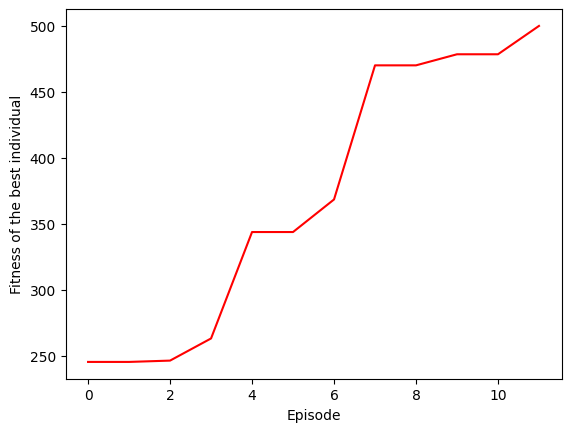

12

In [602]:
agent.train(max_iter=50, crossover=False, reps=10, selection_type=ELITE)

In [ ]:
#env.close()
#env = gym.make("CartPole-v1", render_mode="human")

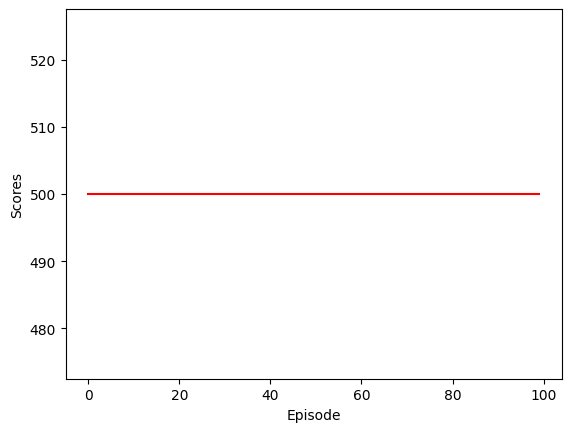

AVG Score after 100 games: 500.0


In [ ]:
sum = 0
scores = []
for i in range(100):
    scores.append(agent.play(agent.population[0][0]))
    display.clear_output()
    plot(scores=scores,ylabel="Scores")

print("AVG Score after 100 games: " + str(np.sum(scores)/100))

# Antworten auf die Fragen

### Warum ist es eventuell nicht die beste Lösung, jedes Individuum nur einmal zu testen?

Bei einmaligen Testen kann durch Zufall und unter guten Bedingungen schnell ein guter Score erreicht werden. Dies heißt aber wiederrum nicht, dass das nn immer gute Ergebnisse liefert. Die Fitness sollte daher als Durschnitt mehrere Durchläufe berechnet werden. Umso mehr Durchläufe für die Berechnung der Fitness verwendet werden, desto stabiler ist das nn, aber auch umso länger dauert das Training.

### Fällt Ihnen eine gute Methode f¨ur ein Crossover ein?

Wir haben ein Crossover implemmentiert (siehe Code), dieses funktioniert auch ganz gut. Nur wird die Trainingzeit dadurch deutlich länger. Da das Training auch ohne funktioniert, wird dieses also nicht benötigt 

### Welche Beobachtungen machen Sie?

Elite, Fitnessproportionale und Tunier Selection funktionieren gleich gut und schnell. Rang Selection hingegen funktioniert sehr schlecht

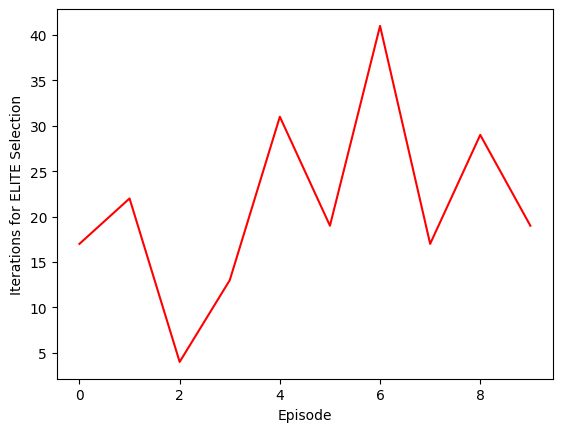

AVG iter after 10 trainings: 21.2


In [598]:
# Test for Elite

iter_l = []
for i in range(10):
    agent = Agent(popSize=20)
    iter_l.append(agent.train(max_iter=50, crossover=False, reps=5, selection_type=ELITE, plot_score = False))
    display.clear_output()
    plot(ylabel= "Iterations for ELITE Selection", scores=iter_l)

print("AVG iter after 10 trainings: " + str(np.sum(iter_l)/10))

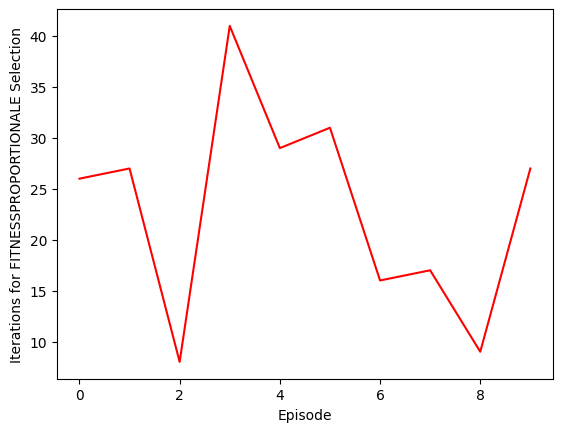

AVG iter after 10 trainings: 23.1


In [599]:
#Test for FITNESSPROPORTIONALE

iter_l = []
for i in range(10):
    agent = Agent(popSize=20)
    iter_l.append(agent.train(max_iter=50, crossover=False, reps=5, selection_type=FITNESSPROPORTIONALE, plot_score = False))
    display.clear_output()
    plot(ylabel= "Iterations for FITNESSPROPORTIONALE Selection", scores=iter_l)

print("AVG iter after 10 trainings: " + str(np.sum(iter_l)/10))

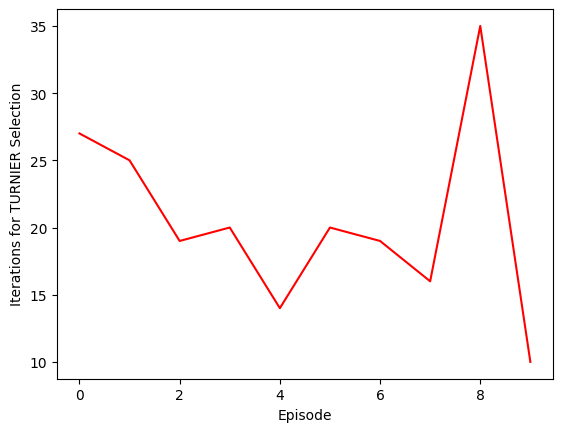

AVG iter after 10 trainings: 20.5


In [600]:
#Test for Turnier

iter_l = []
for i in range(10):
    agent = Agent(popSize=20)
    iter_l.append(agent.train(max_iter=50, crossover=False, reps=5, selection_type=TURNIER, plot_score = False))
    display.clear_output()
    plot(ylabel= "Iterations for TURNIER Selection", scores=iter_l)

print("AVG iter after 10 trainings: " + str(np.sum(iter_l)/10))

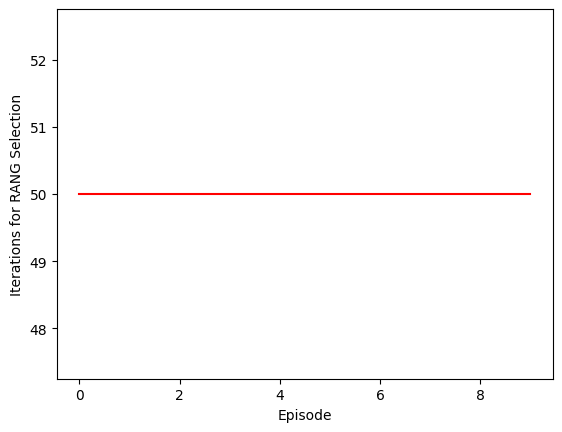

AVG iter after 10 trainings: 50.0


In [601]:
#Test for Rang

iter_l = []
for i in range(10):
    agent = Agent(popSize=20)
    iter_l.append(agent.train(max_iter=50, crossover=False, reps=5, selection_type=RANG, plot_score = False))
    display.clear_output()
    plot(ylabel= "Iterations for RANG Selection", scores=iter_l)

print("AVG iter after 10 trainings: " + str(np.sum(iter_l)/10))